Import libraries

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import shutil
import tarfile
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Define constants

In [0]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_CHANNELS=3
MAX_LENGTH=5
NOT_VALUE_LABEL=10
TRAIN_DATASET_PATH="/content/train"
BATCH_SIZE=32
FILENAME_NAME="filename"
LENGTH_NAME="length"
DIGIT1_NAME="digit1"
DIGIT2_NAME="digit2"
DIGIT3_NAME="digit3"
DIGIT4_NAME="digit4"
DIGIT5_NAME="digit5"
LABELS_LIST=[LENGTH_NAME,DIGIT1_NAME,DIGIT2_NAME,DIGIT3_NAME,DIGIT4_NAME,DIGIT5_NAME]
DROP_RATE=0.2

Copy tar gz files

In [4]:
shutil.copyfile("/content/drive/My Drive/Colab Notebooks/storage/train.tar.gz", "/content/train.tar.gz")
shutil.copyfile("/content/drive/My Drive/Colab Notebooks/storage/test.tar.gz", "/content/test.tar.gz")

'/content/test.tar.gz'

Unzip files

In [0]:
with tarfile.open("/content/train.tar.gz") as tar:
    tar.extractall(path='/content')

In [0]:
with tarfile.open("/content/test.tar.gz") as tar:
    tar.extractall(path='/content')

Prapere training data

In [0]:
def get_labels(mat,ref):
    if len(ref)>1:
        return [int(mat[ref[j].item()][0][0]) for j in range(len(ref))]
    else:
        return [int(ref[0][0])]

In [0]:
def read_mat(path):
    train_mat = h5py.File(path,"r")
    digitStruct=train_mat["digitStruct"]
    bboxes=digitStruct["bbox"]
    names=digitStruct["name"]

    labels = []
    filenames=[]

    for i in range(len(bboxes)):
        bbox=bboxes[i].item()
        target=train_mat[bbox]["label"]
        label=get_labels(train_mat,target)
        label=[0 if digit==10 else digit for digit in label]
        length=(len(label))

        name= ''.join([chr(c[0]) for c in train_mat[names[i][0]]])    

        if(length>MAX_LENGTH):
            continue

        for _ in range(MAX_LENGTH - length):
            label.append(NOT_VALUE_LABEL)
        label.append(length)

        labels.append(label)
        filenames.append(name)

    return np.array(filenames), np.array(labels)

In [0]:
filenames, labels= read_mat("/content/train/digitStruct.mat")

In [10]:
print(filenames.shape)
print(labels.shape)

(33401,)
(33401, 6)


In [0]:
def create_dataframe(filenames, labels):
    return pd.DataFrame({
        FILENAME_NAME: filenames,
        LENGTH_NAME: labels[:,5],
        DIGIT1_NAME: labels[:,0],
        DIGIT2_NAME: labels[:,1],
        DIGIT3_NAME: labels[:,2],
        DIGIT4_NAME: labels[:,3],
        DIGIT5_NAME: labels[:,4]
    })

In [0]:
df=create_dataframe(filenames, labels)

In [13]:
df.head()

,filename,length,digit1,digit2,digit3,digit4,digit5
0,1.png,2,1,9,10,10,10
1,2.png,2,2,3,10,10,10
2,3.png,2,2,5,10,10,10
3,4.png,2,9,3,10,10,10
4,5.png,2,3,1,10,10,10


In [14]:
df.tail()

,filename,length,digit1,digit2,digit3,digit4,digit5
33396,33398.png,1,8,10,10,10,10
33397,33399.png,1,8,10,10,10,10
33398,33400.png,2,9,5,10,10,10
33399,33401.png,2,2,2,10,10,10
33400,33402.png,3,1,6,9,10,10


In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
validation_steps=total_validate//BATCH_SIZE
steps_per_epoch=total_train//BATCH_SIZE

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [18]:
train_generator = image_generator.flow_from_dataframe(
    train_df, 
    TRAIN_DATASET_PATH, 
    x_col=FILENAME_NAME,
    y_col=LABELS_LIST,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    class_mode='multi_output',
    batch_size=BATCH_SIZE
)
validation_generator = image_generator.flow_from_dataframe(
    validate_df, 
    TRAIN_DATASET_PATH, 
    x_col=FILENAME_NAME,
    y_col=LABELS_LIST,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    class_mode='multi_output',
    batch_size=BATCH_SIZE
)

Found 26720 validated image filenames.
Found 6681 validated image filenames.


In [0]:
def show_batch(image_batch,label_batch):    
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,8,n+1)
        plt.imshow(image_batch[n])
        length=label_batch[0][n]
        title=''.join([str(label_batch[c+1][n]) for c in range(length)])
        plt.title(title)
        plt.axis('off')

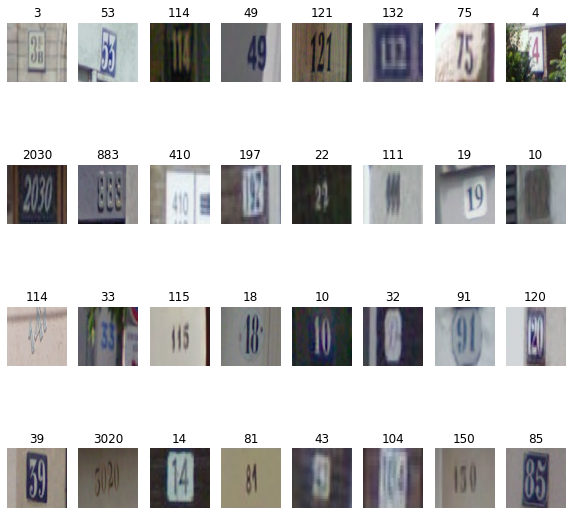

In [20]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

Create model

In [0]:
input=tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), name="input")

hidden1=tf.keras.layers.Conv2D(48,(5,5),activation='relu',padding="same")(input)
hidden1=tf.keras.layers.BatchNormalization()(hidden1)
hidden1=tf.keras.layers.MaxPooling2D(padding="same")(hidden1)
hidden1=tf.keras.layers.Dropout(DROP_RATE)(hidden1)

hidden2=tf.keras.layers.Conv2D(64,(5,5),activation='relu',padding="same")(hidden1)
hidden2=tf.keras.layers.BatchNormalization()(hidden2)
hidden2=tf.keras.layers.MaxPooling2D(padding="same",strides=1)(hidden2)
hidden2=tf.keras.layers.Dropout(DROP_RATE)(hidden2)

hidden3=tf.keras.layers.Conv2D(128,(5,5),activation='relu',padding="same")(hidden2)
hidden3=tf.keras.layers.BatchNormalization()(hidden3)
hidden3=tf.keras.layers.MaxPooling2D(padding="same")(hidden3)
hidden3=tf.keras.layers.Dropout(DROP_RATE)(hidden3)

hidden4=tf.keras.layers.Conv2D(160,(5,5),activation='relu',padding="same")(hidden3)
hidden4=tf.keras.layers.BatchNormalization()(hidden4)
hidden4=tf.keras.layers.MaxPooling2D(padding="same",strides=1)(hidden4)
hidden4=tf.keras.layers.Dropout(DROP_RATE)(hidden4)

hidden5=tf.keras.layers.Conv2D(192,(5,5),activation='relu',padding="same")(hidden4)
hidden5=tf.keras.layers.BatchNormalization()(hidden5)
hidden5=tf.keras.layers.MaxPooling2D(padding="same")(hidden5)
hidden5=tf.keras.layers.Dropout(DROP_RATE)(hidden5)

hidden6=tf.keras.layers.Conv2D(192,(5,5),activation='relu',padding="same")(hidden5)
hidden6=tf.keras.layers.BatchNormalization()(hidden6)
hidden6=tf.keras.layers.MaxPooling2D(padding="same",strides=1)(hidden6)
hidden6=tf.keras.layers.Dropout(DROP_RATE)(hidden6)

hidden7=tf.keras.layers.Conv2D(192,(5,5),activation='relu',padding="same")(hidden6)
hidden7=tf.keras.layers.BatchNormalization()(hidden7)
hidden7=tf.keras.layers.MaxPooling2D(padding="same")(hidden7)
hidden7=tf.keras.layers.Dropout(DROP_RATE)(hidden7)

hidden8=tf.keras.layers.Conv2D(192,(5,5),activation='relu',padding="same")(hidden7)
hidden8=tf.keras.layers.BatchNormalization()(hidden8)
hidden8=tf.keras.layers.MaxPooling2D(padding="same",strides=1)(hidden8)
hidden8=tf.keras.layers.Dropout(DROP_RATE)(hidden8)

hidden9=tf.keras.layers.Flatten()(hidden8)      
hidden9=tf.keras.layers.Dense(4096, activation='relu')(hidden9)

hidden10=tf.keras.layers.Dense(4096, activation='relu')(hidden9)

length=tf.keras.layers.Dense(6, activation='softmax', name=LENGTH_NAME)(hidden10)
digit1=tf.keras.layers.Dense(11, activation='softmax', name=DIGIT1_NAME)(hidden10)
digit2=tf.keras.layers.Dense(11, activation='softmax', name=DIGIT2_NAME)(hidden10)
digit3=tf.keras.layers.Dense(11, activation='softmax', name=DIGIT3_NAME)(hidden10)
digit4=tf.keras.layers.Dense(11, activation='softmax', name=DIGIT4_NAME)(hidden10)
digit5=tf.keras.layers.Dense(11, activation='softmax', name=DIGIT5_NAME)(hidden10)

model = tf.keras.Model(inputs=input, outputs=[length,digit1,digit2,digit3,digit4,digit5], name='svhn_model')

In [22]:
model.summary()

Model: "svhn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 48) 3648        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 48)   0           batch_normalization[0][0]        
_________________________________________________________________________________________

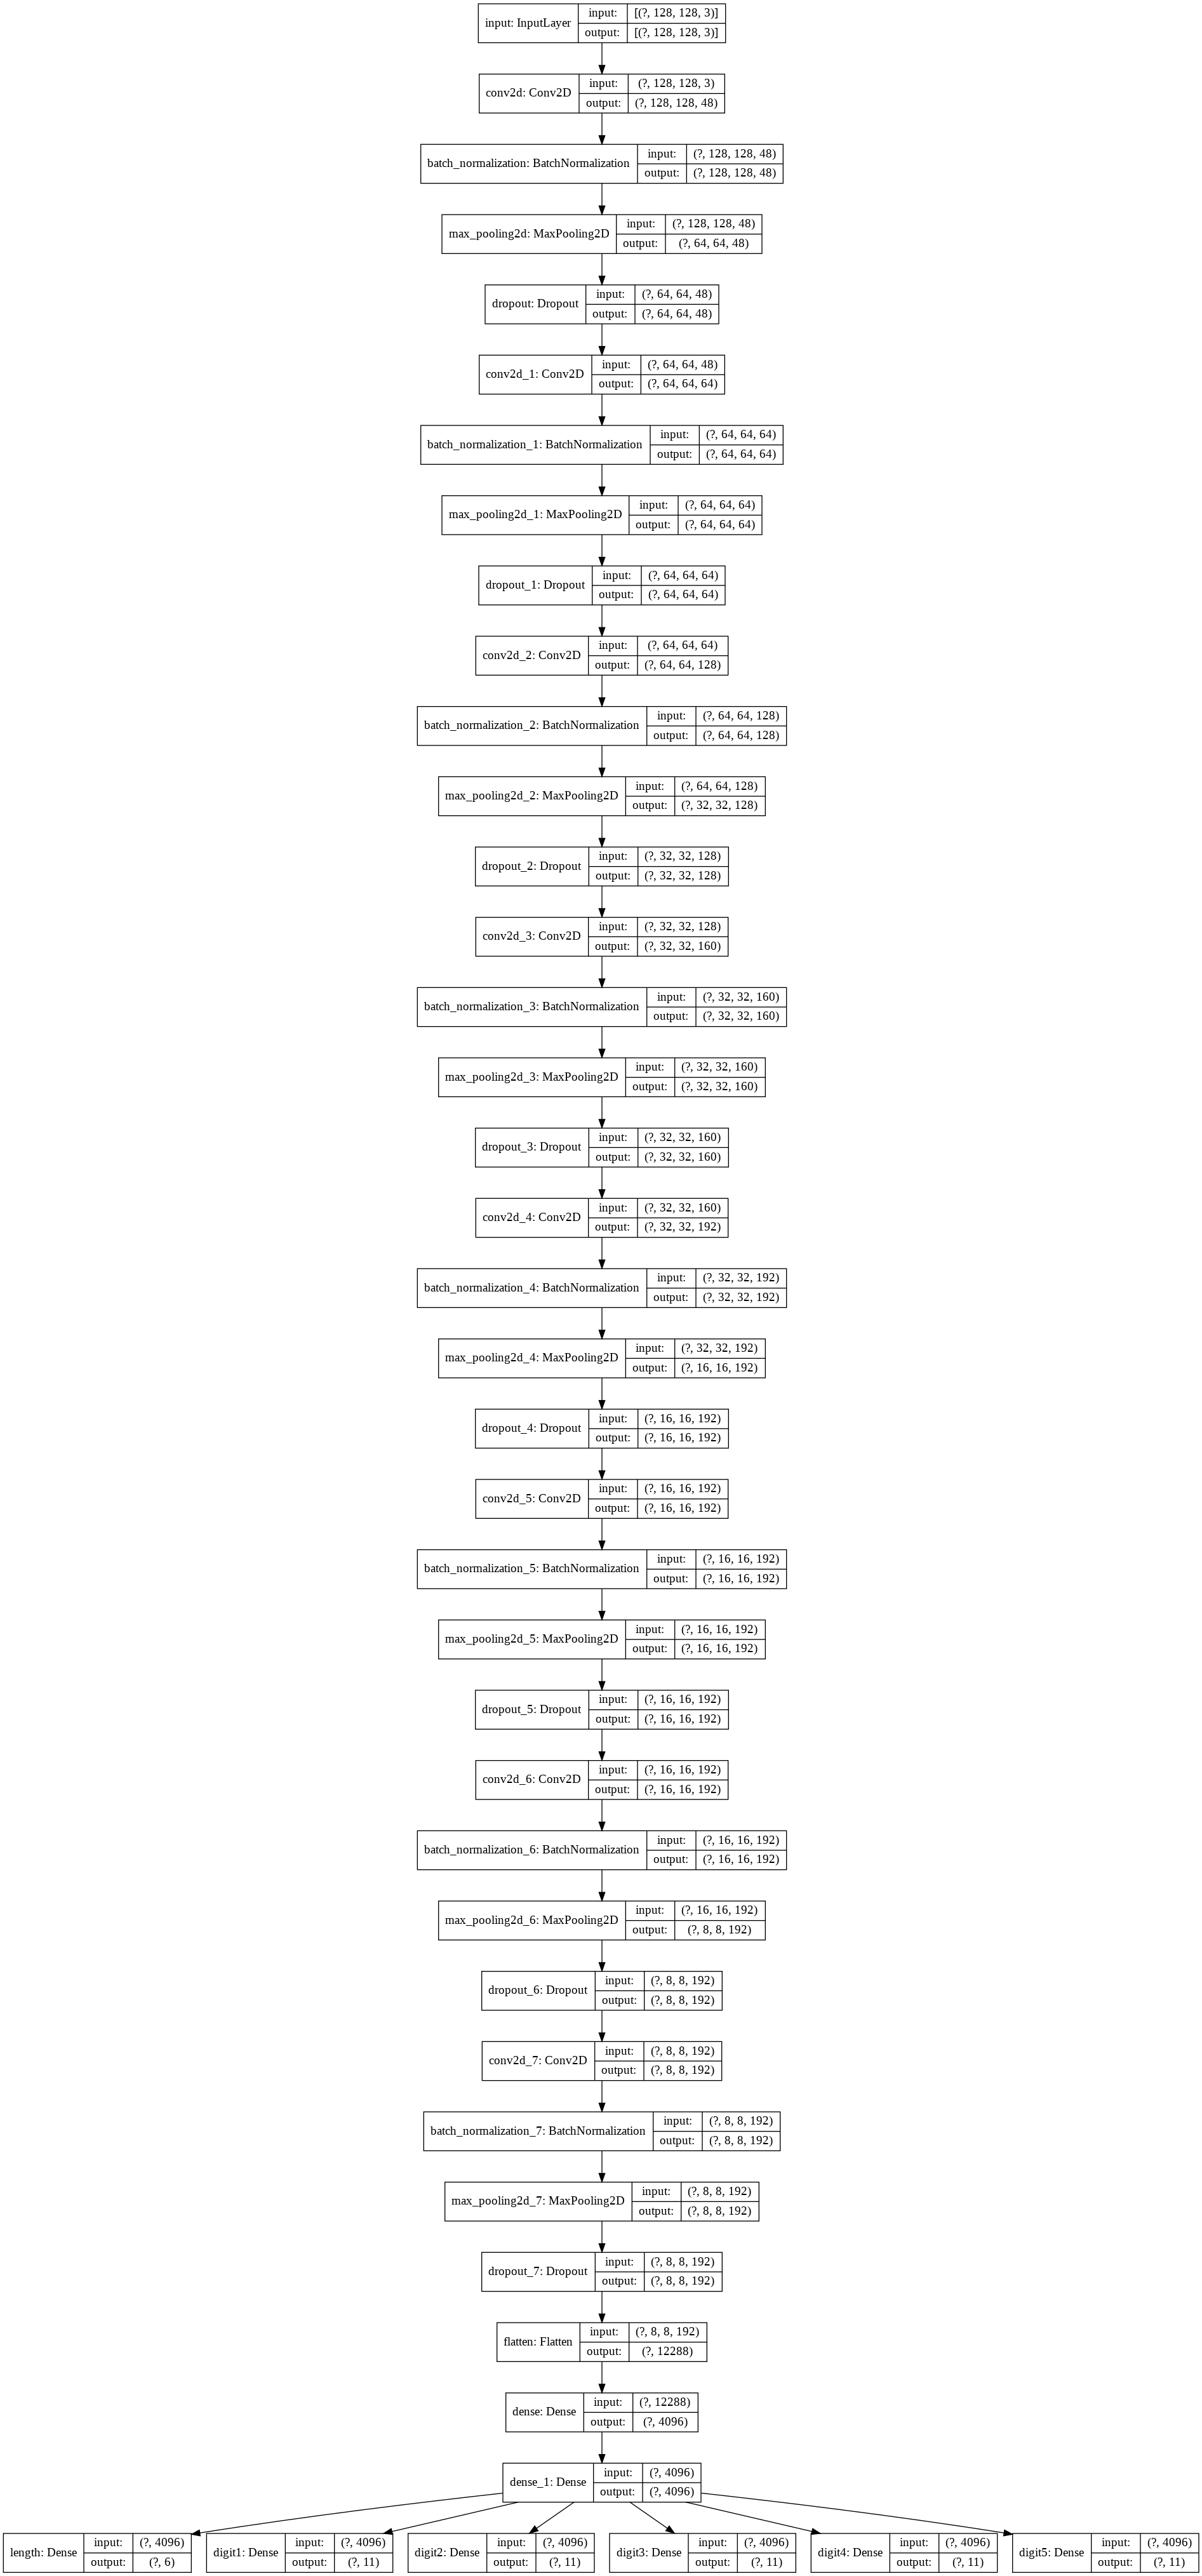

In [23]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [0]:
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Fit model

In [28]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/lab4_results/model.ckpt")

In [0]:
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/Colab Notebooks/lab4_results/model.ckpt",
    save_weights_only=True,
    verbose=1
    )

In [35]:
model.fit(train_generator, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch,
    callbacks=[model_cp_callback],
    initial_epoch=35
    )

Epoch 36/50
835/835 [==============================] - ETA: 0s - loss: 1.2588 - length_loss: 0.1123 - digit1_loss: 0.3430 - digit2_loss: 0.4543 - digit3_loss: 0.2813 - digit4_loss: 0.0651 - digit5_loss: 0.0029 - length_accuracy: 0.9592 - digit1_accuracy: 0.8898 - digit2_accuracy: 0.8477 - digit3_accuracy: 0.9062 - digit4_accuracy: 0.9812 - digit5_accuracy: 0.9995
Epoch 00036: saving model to /content/drive/My Drive/Colab Notebooks/lab4_results/model.ckpt
835/835 [==============================] - 64s 77ms/step - loss: 1.2588 - length_loss: 0.1123 - digit1_loss: 0.3430 - digit2_loss: 0.4543 - digit3_loss: 0.2813 - digit4_loss: 0.0651 - digit5_loss: 0.0029 - length_accuracy: 0.9592 - digit1_accuracy: 0.8898 - digit2_accuracy: 0.8477 - digit3_accuracy: 0.9062 - digit4_accuracy: 0.9812 - digit5_accuracy: 0.9995 - val_loss: 2.4885 - val_length_loss: 0.4131 - val_digit1_loss: 0.6347 - val_digit2_loss: 0.7944 - val_digit3_loss: 0.5124 - val_digit4_loss: 0.1303 - val_digit5_loss: 0.0037 - val_

Prapere testing data

In [0]:
test_filenames, test_labels= read_mat("/content/test/digitStruct.mat")

In [37]:
print(test_filenames.shape)
print(test_labels.shape)

(13068,)
(13068, 6)


In [0]:
test_df=create_dataframe(test_filenames, test_labels)

In [39]:
test_df.head()

,filename,length,digit1,digit2,digit3,digit4,digit5
0,1.png,1,5,10,10,10,10
1,2.png,3,2,1,0,10,10
2,3.png,1,6,10,10,10,10
3,4.png,1,1,10,10,10,10
4,5.png,1,9,10,10,10,10


In [40]:
test_df.tail()

,filename,length,digit1,digit2,digit3,digit4,digit5
13063,13064.png,2,1,0,10,10,10
13064,13065.png,2,1,7,10,10,10
13065,13066.png,3,1,3,6,10,10
13066,13067.png,3,2,2,7,10,10
13067,13068.png,2,6,7,10,10,10


In [41]:
test_generator = image_generator.flow_from_dataframe(
    test_df, 
    "/content/test", 
    x_col=FILENAME_NAME,
    y_col=LABELS_LIST,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    class_mode='multi_output',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13068 validated image filenames.


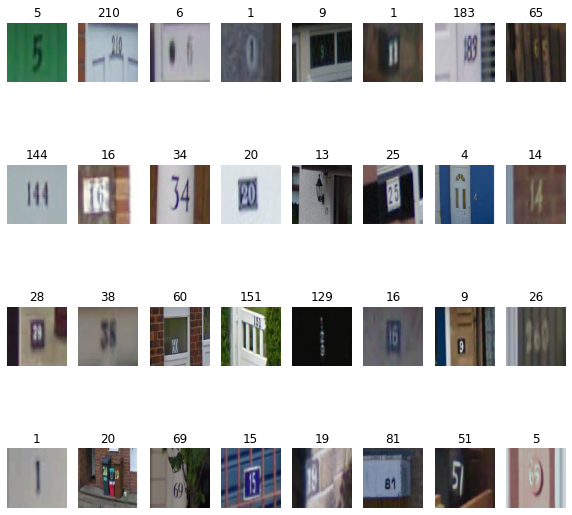

In [42]:
image_batch, label_batch = next(test_generator)
show_batch(image_batch, label_batch)

Evaluate model

In [43]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/lab4_results/model.ckpt")

In [44]:
model.evaluate(test_generator)

  57462/Unknown - 2391s 42ms/step - loss: 5.4104 - length_loss: 1.0205 - digit1_loss: 1.5757 - digit2_loss: 1.9700 - digit3_loss: 0.7476 - digit4_loss: 0.0936 - digit5_loss: 0.0031 - length_accuracy: 0.8076 - digit1_accuracy: 0.6869 - digit2_accuracy: 0.6291 - digit3_accuracy: 0.8603 - digit4_accuracy: 0.9912 - digit5_accuracy: 0.9998Buffered data was truncated after reaching the output size limit.

Predict

In [0]:
image_batch, label_batch = next(test_generator)

In [0]:
predict=model.predict(image_batch)

In [0]:
predicted_length=np.argmax(predict[0], axis=-1)
predicted_digit1=np.argmax(predict[1], axis=-1)
predicted_digit2=np.argmax(predict[2], axis=-1)
predicted_digit3=np.argmax(predict[3], axis=-1)
predicted_digit4=np.argmax(predict[4], axis=-1)
predicted_digit5=np.argmax(predict[5], axis=-1)

In [0]:
predicted_label=[predicted_length,predicted_digit1,predicted_digit2,predicted_digit3,predicted_digit4,predicted_digit5]

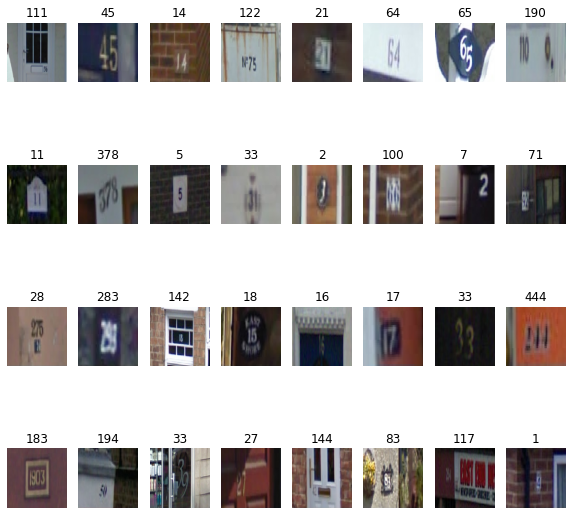

In [50]:
show_batch(image_batch, predicted_label)

In [71]:
custom_generator=image_generator.flow_from_directory(
    "/content/photo",
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    class_mode=None,
    shuffle=False,
    batch_size=4)

Found 4 images belonging to 2 classes.


In [0]:
image_batch = next(custom_generator)
predict_photo=model.predict(image_batch)
predicted_length=np.argmax(predict_photo[0], axis=-1)
predicted_digit1=np.argmax(predict_photo[1], axis=-1)
predicted_digit2=np.argmax(predict_photo[2], axis=-1)
predicted_digit3=np.argmax(predict_photo[3], axis=-1)
predicted_digit4=np.argmax(predict_photo[4], axis=-1)
predicted_digit5=np.argmax(predict_photo[5], axis=-1)
predicted_label=[predicted_length,predicted_digit1,predicted_digit2,predicted_digit3,predicted_digit4,predicted_digit5]

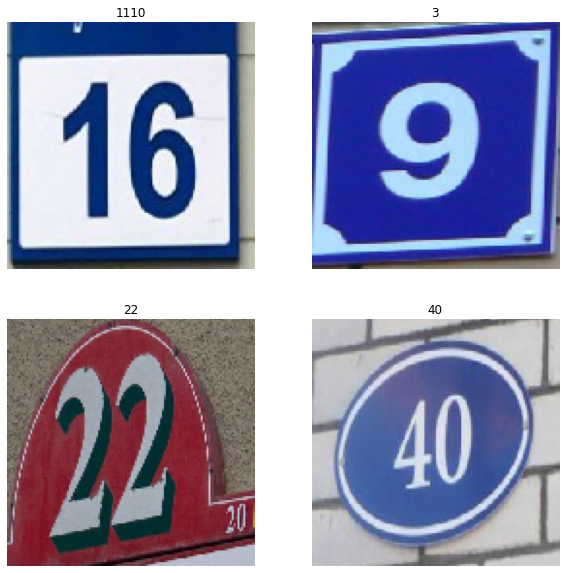

In [73]:
plt.figure(figsize=(10,10))
for n in range(4):
    ax = plt.subplot(2,2,n+1)
    plt.imshow(image_batch[n])
    length=predicted_label[0][n]
    title=''.join([str(predicted_label[c+1][n]) for c in range(length)])
    plt.title(title)
    plt.axis('off')